In [4]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow.keras import layers
import time
from IPython import display
import torch

In [5]:
tf.debugging.set_log_device_placement(True)

In [6]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [7]:
(train_images, train_labels),(_,_) = tf.keras.datasets.mnist.load_data()

In [8]:
train_images= train_images.reshape(train_images.shape[0], 28,28,1).astype('float32')
train_images = (train_images -127.5)/127.5 #-1 to 1

In [9]:
BUFFER_SIZE = 600000
BATCH_SIZE = 256

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DummySeedGenerator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShuffleDatasetV3 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op BatchDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0


2025-08-08 20:58:01.801727: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-08-08 20:58:01.801768: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-08-08 20:58:01.801774: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-08-08 20:58:01.801811: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-08-08 20:58:01.801827: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-08-08 20:58:01.810452: I tensorflow/core/common_runtime/placer.cc:125] input: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-08-08 20:58:01.810483: I tensorflow/core/

In [11]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256 , use_bias=False , input_shape = (100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7,7,256)))
    assert model.output_shape == (None , 7,7,256)

   
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op FloorMod in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomUniformV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-08 20:58:02.107995: I tensorflow/core/common_runtime/placer.cc:125] input: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-08-08 20:58:02.108007: I tensorflow/core/common_runtime/placer.cc:125] _EagerConst: (_EagerConst): /job:localhost/replica:0/task:0/device:GPU:0
2025-08-08 20:58:02.108010: I tensorflow/core/common_runtime/placer.cc:125] output_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-08-08 20:58:02.108996: I tensorflow/core/common_runtime/placer.cc:125] x: (_DeviceArg): /job:localhost/replica:0/task:0/device:GPU:0
2025-08-08 20:58:02.109003: I tensorflow/core/common_runtime/placer.cc:125] Cast: (Cast): /job:

Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:

2025-08-08 20:58:02.312737: I tensorflow/core/common_runtime/placer.cc:125] x: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-08-08 20:58:02.312748: I tensorflow/core/common_runtime/placer.cc:125] y: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-08-08 20:58:02.312751: I tensorflow/core/common_runtime/placer.cc:125] Mul: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
2025-08-08 20:58:02.312754: I tensorflow/core/common_runtime/placer.cc:125] z_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-08-08 20:58:02.343523: I tensorflow/core/common_runtime/placer.cc:125] x: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-08-08 20:58:02.343531: I tensorflow/core/common_runtime/placer.cc:125] y: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-08-08 20:58:02.343535: I tensorflow/core/common_runtime/placer.cc:125] AddV2: (AddV2): /job:localhost/replica:0/task:0/device:GPU:0
2025-08-08 20:58:02.343537: I tensorflow/core/common_runtime

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localh

2025-08-08 20:58:02.516656: I tensorflow/core/common_runtime/placer.cc:125] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-08-08 20:58:02.516667: I tensorflow/core/common_runtime/placer.cc:125] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-08-08 20:58:02.517304: I tensorflow/core/common_runtime/placer.cc:125] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-08-08 20:58:02.517310: I tensorflow/core/common_runtime/placer.cc:125] value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-08-08 20:58:02.517313: I tensorflow/core/common_runtime/placer.cc:125] AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-08-08 20:58:02.523489: I tensorflow/core/common_runtime/placer.cc:125] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-08-08 20:58:02.523504: I tensorflow/core/common_runtime/placer.cc:125] VarHandleOp: (VarHandleOp): /job:localhost/

Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op MatMul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Rsqrt in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/devic

2025-08-08 20:58:02.796605: I tensorflow/core/common_runtime/placer.cc:125] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-08-08 20:58:02.796618: I tensorflow/core/common_runtime/placer.cc:125] ReadVariableOp: (ReadVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-08-08 20:58:02.796620: I tensorflow/core/common_runtime/placer.cc:125] value_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-08-08 20:58:02.797259: I tensorflow/core/common_runtime/placer.cc:125] a: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-08-08 20:58:02.797263: I tensorflow/core/common_runtime/placer.cc:125] b: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-08-08 20:58:02.797266: I tensorflow/core/common_runtime/placer.cc:125] MatMul: (MatMul): /job:localhost/replica:0/task:0/device:GPU:0
2025-08-08 20:58:02.797267: I tensorflow/core/common_runtime/placer.cc:125] product_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-08-0

Executing op Shape in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Reshape in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Shape in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Conv2DBackpropInput in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Rsqrt in device /job:local

2025-08-08 20:58:03.013259: I tensorflow/core/common_runtime/placer.cc:125] input: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-08-08 20:58:03.013270: I tensorflow/core/common_runtime/placer.cc:125] Shape: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
2025-08-08 20:58:03.013272: I tensorflow/core/common_runtime/placer.cc:125] output_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-08-08 20:58:03.014363: I tensorflow/core/common_runtime/placer.cc:125] tensor: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-08-08 20:58:03.014368: I tensorflow/core/common_runtime/placer.cc:125] shape: (_DeviceArg): /job:localhost/replica:0/task:0/device:CPU:0
2025-08-08 20:58:03.014371: I tensorflow/core/common_runtime/placer.cc:125] Reshape: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
2025-08-08 20:58:03.014372: I tensorflow/core/common_runtime/placer.cc:125] output_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-08-08 20

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Rsqrt in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LeakyRelu in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Shape in device /job:localhost/replica:0/task:0/device:GPU:0
Execut

2025-08-08 20:58:03.215325: I tensorflow/core/common_runtime/placer.cc:125] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-08-08 20:58:03.215337: I tensorflow/core/common_runtime/placer.cc:125] ReadVariableOp: (ReadVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-08-08 20:58:03.215340: I tensorflow/core/common_runtime/placer.cc:125] value_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-08-08 20:58:03.230403: I tensorflow/core/common_runtime/placer.cc:125] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-08-08 20:58:03.230414: I tensorflow/core/common_runtime/placer.cc:125] ReadVariableOp: (ReadVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-08-08 20:58:03.230416: I tensorflow/core/common_runtime/placer.cc:125] value_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-08-08 20:58:03.279369: I tensorflow/core/common_runtime/placer.cc:125] x: (_Arg): /job:localhost/replica:0/task:0/d

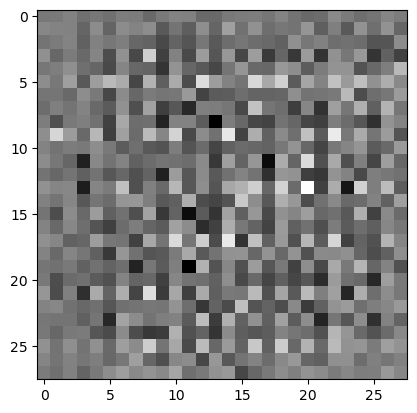

In [12]:
generator  = make_generator_model()

noise = tf.random.normal([1,100])
generated_image = generator(noise , training=False)

plt.imshow(generated_image[0,:,:,0] , cmap ='grey')

In [13]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [14]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op FloorMod in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StatelessRandomUniformV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:loca

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-08 20:58:04.020172: I tensorflow/core/common_runtime/placer.cc:125] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-08-08 20:58:04.020190: I tensorflow/core/common_runtime/placer.cc:125] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-08-08 20:58:04.024258: I tensorflow/core/common_runtime/placer.cc:125] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-08-08 20:58:04.024272: I tensorflow/core/common_runtime/placer.cc:125] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-08-08 20:58:04.029923: I tensorflow/core/common_ru

Executing op Squeeze in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op BiasAdd in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LeakyRelu in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Conv2D in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Reshape in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Squeeze in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op BiasAdd in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LeakyRelu in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Shape in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/de

2025-08-08 20:58:04.210323: I tensorflow/core/common_runtime/placer.cc:125] value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-08-08 20:58:04.210327: I tensorflow/core/common_runtime/placer.cc:125] bias: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-08-08 20:58:04.210330: I tensorflow/core/common_runtime/placer.cc:125] BiasAdd: (BiasAdd): /job:localhost/replica:0/task:0/device:GPU:0
2025-08-08 20:58:04.210332: I tensorflow/core/common_runtime/placer.cc:125] output_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-08-08 20:58:04.267983: I tensorflow/core/common_runtime/placer.cc:125] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-08-08 20:58:04.267995: I tensorflow/core/common_runtime/placer.cc:125] ReadVariableOp: (ReadVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-08-08 20:58:04.267998: I tensorflow/core/common_runtime/placer.cc:125] value_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2

In [15]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [16]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [17]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [18]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0


2025-08-08 20:58:05.225493: I tensorflow/core/common_runtime/placer.cc:125] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-08-08 20:58:05.225507: I tensorflow/core/common_runtime/placer.cc:125] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-08-08 20:58:05.226249: I tensorflow/core/common_runtime/placer.cc:125] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-08-08 20:58:05.226254: I tensorflow/core/common_runtime/placer.cc:125] value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-08-08 20:58:05.226259: I tensorflow/core/common_runtime/placer.cc:125] AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-08-08 20:58:05.227657: I tensorflow/core/common_runtime/placer.cc:125] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-08-08 20:58:05.227666: I tensorflow/core/common_runtime/placer.cc:125] VarHandleOp: (VarHandleOp): /job:localhost/

In [19]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [20]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0


In [21]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [22]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [23]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op MatMul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Rsqrt in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0


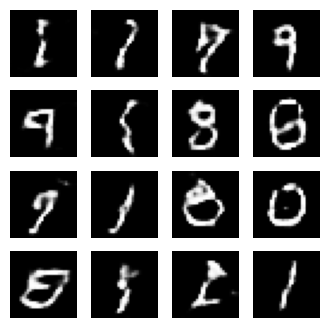

In [24]:
train(train_dataset, EPOCHS)

In [25]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Executing op RestoreV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op NoOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op NoOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op NoOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op NoOp in device /job:localhost/replica:0/ta

2025-08-08 21:07:53.039765: I tensorflow/core/common_runtime/placer.cc:125] prefix: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-08-08 21:07:53.039775: I tensorflow/core/common_runtime/placer.cc:125] tensor__names: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-08-08 21:07:53.039778: I tensorflow/core/common_runtime/placer.cc:125] shape__and__slices: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-08-08 21:07:53.039781: I tensorflow/core/common_runtime/placer.cc:125] RestoreV2: (RestoreV2): /job:localhost/replica:0/task:0/device:CPU:0
2025-08-08 21:07:53.039782: I tensorflow/core/common_runtime/placer.cc:125] tensors_0_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2025-08-08 21:07:53.039783: I tensorflow/core/common_runtime/placer.cc:125] tensors_1_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2025-08-08 21:07:53.039785: I tensorflow/core/common_runtime/placer.cc:125] tensors_2_RetVal: (_Retval): /job:localhost/repli

In [26]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

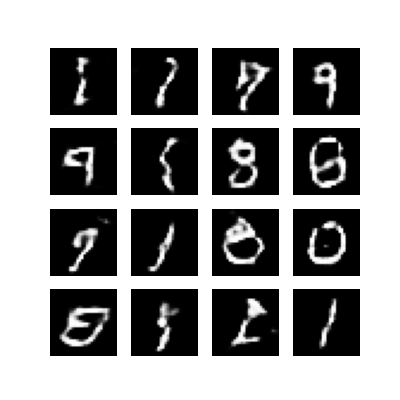

In [27]:
display_image(EPOCHS)

In [28]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

/var/folders/br/3n7cw9fs06z3gbzs6yw2x1xr0000gn/T/ipykernel_5890/1982054950.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
/var/folders/br/3n7cw9fs06z3gbzs6yw2x1xr0000gn/T/ipykernel_5890/1982054950.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


  Cloning https://github.com/tensorflow/docs to /private/var/folders/br/3n7cw9fs06z3gbzs6yw2x1xr0000gn/T/pip-req-build-n6tr2674
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /private/var/folders/br/3n7cw9fs06z3gbzs6yw2x1xr0000gn/T/pip-req-build-n6tr2674
  Resolved https://github.com/tensorflow/docs to commit fcba6dc4dee6cf9c438370101b5acbd6789b77f3
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2025.3.6.10029-py3-none-any.whl size=186351 sha256=8334402be7ae2e662e12f7535d4807996bdf34a06ce31e16a89ea5c2ba6ac363
  Stored in directory: /private/var/folders/br/3n7cw9fs06z3gbzs6yw2x1xr0000gn/T/pip-ephem-wheel-cache-vybp24fk/wheels/3e/88/34/48d2789bc9d37b33ddce06bccc454fae0285e5396d0a5be9d9
Successfully built tensorflow-docs



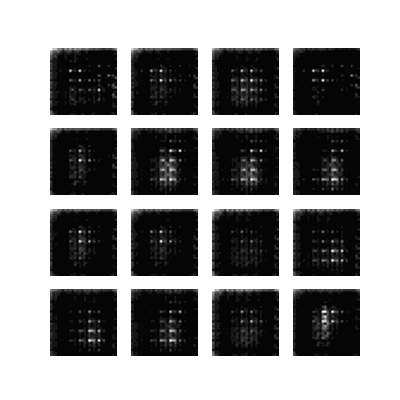

  Cloning https://github.com/tensorflow/docs to /private/var/folders/br/3n7cw9fs06z3gbzs6yw2x1xr0000gn/T/pip-req-build-kap1cadi
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /private/var/folders/br/3n7cw9fs06z3gbzs6yw2x1xr0000gn/T/pip-req-build-kap1cadi
  Resolved https://github.com/tensorflow/docs to commit fcba6dc4dee6cf9c438370101b5acbd6789b77f3
  Preparing metadata (setup.py) ... done



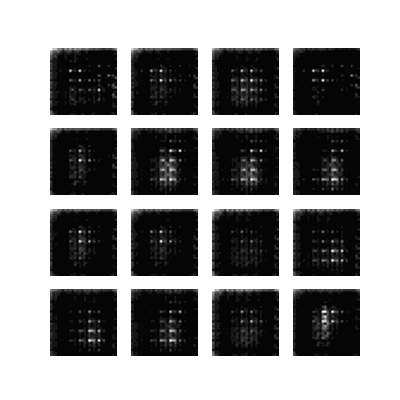

In [32]:
# First, install the tensorflow-docs package
!pip install git+https://github.com/tensorflow/docs

# Then import and use the module
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

  Cloning https://github.com/tensorflow/docs to /private/var/folders/br/3n7cw9fs06z3gbzs6yw2x1xr0000gn/T/pip-req-build-2yssziah
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /private/var/folders/br/3n7cw9fs06z3gbzs6yw2x1xr0000gn/T/pip-req-build-2yssziah
  Resolved https://github.com/tensorflow/docs to commit fcba6dc4dee6cf9c438370101b5acbd6789b77f3
  Preparing metadata (setup.py) ... done



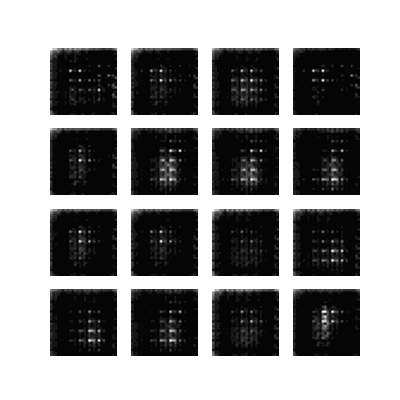

In [33]:

import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)